In [3]:
from commonfunctions import *
import skimage as sk 
import numpy as np
import matplotlib as mp
import scipy as sp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from queue import PriorityQueue


interactive(children=(IntSlider(value=10, description='x', max=300), Output()), _dom_classes=('widget-interact…

(48, 655)


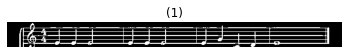

In [12]:
img = sk.io.imread('imgs/test2.png',as_gray=True)
img = img.astype(np.float64) / np.max(img) 
img = 255 * img 
img = img.astype(np.uint8)

    
    
    
def binarize(img,block_size = 35):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b


def deskew(img,delta=1,limit=60):
    def find_score(arr, angle):
        data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    delta = .5
    limit = 30
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
       hist, score = find_score(img, angle)
       scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))
    #correct skew
    img_n = sp.ndimage.interpolation.rotate(img, best_angle, reshape=False, order=0)
    return img_n




def line_detection(img):
    
    bounding_boxes = sk.measure.find_contours(img,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 
            
            #lines.append(int(Ymin))
            #lines.append(int(Ymax))
            #print("sdsd")
    #show_images([newImg])
    newImg = sk.morphology.closing(newImg)
    bounding_boxes = sk.measure.find_contours(newImg,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 

            lines.append(int(Ymin))
            lines.append(int(Ymax))
            #print("sdsd")
    #show_images([newImg])
#     lines = np.sort(lines)
#     print(lines)
#     l = [lines[0]]
#     for i in range(1,len(lines)):
#         if lines[i]-lines[i-1] < 3:
#             continue
#         elif i == len(lines)-1:
#             l.append(lines[i])
#         else:
#             l.append(lines[i-1])
#             l.append(lines[i])
            
            
    return lines
 
def convertToLineSpace(row,lines):
    if row < lines[0]:
        return (-1,-1)
    if row == lines[0]:
        return (0,0)
    for i in range(1,len(lines)):
        if row == lines[i]:
            if i%2 == 0:
                return (5*(i)//2,5*(i)//2)
            else:
                return (5*((i)//2) + 4,5*((i)//2) + 4)
        if row < lines[i] and row > lines[i-1]:
            x = (lines[i]-lines[i-1])/3
            y = int((row-lines[i-1])/x)
            if i%2 == 1:                
                return ((5*((i-1)//2))+y,(5*((i-1)//2))+y+1)
            else:
                return (5*((i-2)//2) + 4,5*((i-2)//2) + 5)
    return (5*len(lines),5*len(lines))


img = binarize(img)
#img = deskew(img,1)
img_o = np.copy(img)
#show_images([img_o])
img_thin = sk.morphology.skeletonize(img == True)


w  = 5
se = np.zeros((1,int(img.shape[1]*0.25)))
se1 = np.ones((3,2*w))
for i in range(se.shape[1]):
    se[0,i] = 1


#img_thin = img_thin > t
for i in range(1):
   img_thin = sk.morphology.dilation(img_thin,se1)
   img_thin = sk.morphology.dilation(img_thin,se1)

#img_thin = sk.morphology.skeletonize(img_thin == True)
img_thin = sk.morphology.closing(img_thin)


#img_lines,lines = line_detection(img_thin)
img_thin = sk.morphology.erosion(img_thin,se,shift_x=False, shift_y=False)
lines = line_detection(img_thin)
#print((lines))
def f(x):
    #pass
    global lines
    print(convertToLineSpace(x,lines))
interact(f, x=widgets.IntSlider(min=0, max=300, step=1, value=10));
#img = sk.morphology.skeletonize(img == True)
#se2 = [[0,1,0],[0,1,0],[0,1,0]]
#img = sk.morphology.erosion(img,se2)
#se2 = [[0,1,0],[1,1,1],[0,1,0]]
#img = sk.morphology.dilation(img,se2)


        
# remove staff lines        
newImg = np.copy(img)

def runs_of_ones_array(bits):
    #print(np.invert(bits))
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], bits, [0]))
    # get 1 at run starts and -1 at run ends
    difs = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends, = np.where(difs < 0)
    return run_ends - run_starts


def verticalRunLength(img):
    # white runs 
    arr = []
    for i in range(0,img.shape[1]):
        a = runs_of_ones_array(img[:,i])
        for x in a:
            arr.append(x)
    #print(arr)
    counts = np.bincount(arr)
    staff_height = np.argmax(counts)
    # black runs
    arr = []
    for i in range(0,img.shape[1]):
        a = runs_of_ones_array(np.invert(img[:,i]))
        for x in a:
            arr.append(x)
    #print(arr)
    counts = np.bincount(arr)
    staff_space = np.argmax(counts)
    return staff_height,staff_space

def removeMusicalNotes(img,T_LEN):
    newImg = np.copy(img)
    for i in range(0,img.shape[1]):
        arr = runs_of_ones_array(img[:,i])
        #print(arr)
        k = 0
        j = 0
        while j < img.shape[0]:
            if img[j][i] == True:
                if arr[k] > T_LEN:
                    for x in range(0,arr[k]):
                        newImg[j][i] = False
                        j += 1
                else:
                    j += arr[k]-1
                k += 1
            j += 1
    return newImg
                    
def modelStaffLineShape(staffImg,K=5,T=5):
    O_arr = []
    for i in range(staffImg.shape[1]):
        conn_comp = runs_of_ones_array(img[:,i])
        if len(conn_comp) < T:
            continue
        j = 0
        indx = 0
        O_I = 0
        
        while j < img.shape[0]:
            if img[j][i] == True:
                O_T = 0
                k = 1
                mid = int(j + conn_comp[indx]//2)
                while k < K and i+k < img.shape[1]:
                    c1 = runs_of_ones_array(img[:,i+k])
                    j1 = 0
                    indx1 = 0
                    dist = 10000
                    while j1 < img.shape[0]:
                        if img[j1][i+k] == True:
                            mid1 = int(j1+c1[indx1]//2)
                            if abs(dist) > abs(mid1-mid):
                                dist = mid1-mid
                            else:
                                break
                            j1 += c1[indx1]-1
                            indx1 += 1
                        j1 += 1
                        
                    
                    O_T += (1/(i+k))*(dist)
                    k += 1
                j += conn_comp[indx]-1
                indx += 1
                O_I += O_T
            j += 1
        O_I *= (1/len(conn_comp))
        O_arr.append(O_I)
    return O_arr
def removeStaffLines(img,T_LEN):
    newImg = np.copy(img)
    for i in range(0,img.shape[1]):
        arr = runs_of_ones_array(img[:,i])
        #print(arr)
        k = 0
        j = 0
        while j < img.shape[0]:
            if img[j][i] == True:
                if arr[k] < T_LEN:
                    for x in range(0,arr[k]):
                        newImg[j][i] = False
                        j += 1
                else:
                    j += arr[k]-1
                k += 1
            j += 1
    return newImg                


#staff_img = removeMusicalNotes(newImg,T_LEN)

#O_arr = modelStaffLineShape(staff_img)
#print(O_arr)
#show_images([newImg,removeMusicalNotes(newImg,T_LEN)])
# remove musical notes longer than T_LEN
'''
removed_lines = newImg^removeMusicalNotes(newImg,T_LEN)
show_images([removed_lines])
newImgs = []
i = 0
while True:
    #print(i)
    r0 = lines[i]
    r1 = lines[i+1]
    r0 = int(r0)
    r1 = int(r1)
    
    i += 2
    
    if r1-r0 < 6 or r1 < 0 or r0 < 0:
        if i >= len(lines):
            break
        continue
    newImg = np.array(((r1-r0),img.shape[1]))
    newImg = removed_lines[r0-2:r1+2,:]
    newImgs.append(newImg)
    if i >= len(lines):
        break
#show_images([img])
show_images(newImgs)
'''


def calcWeightFunc(p,q):
    if p == q:
        if p or q:
            return 2
        return 6
    if p or q:
        return 2*np.sqrt(2)
    return 6*np.sqrt(2)

def constructGraph(img):
    di = [0,0,1,-1]
    dj = [1,-1,0,0]
    indx = 0
    graph = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(4):
                ni = i + di[k]
                nj = j + dj[k]
                if ni>=0 and ni<img.shape[0] and nj>=0 and nj<img.shape[1]:
                    w = calcWeightFunc(img[i][j],img[ni][nj])
                    indx2 = ni*img.shape[1]+nj
                    if indx in graph:
                        graph[indx].append({'node':indx2,'w':w})
                    else:
                        graph[indx] = [{'node':indx2,'w':w}]
                    
            indx += 1
    return graph
newImgs = []
i = 0
while True:
    #print(i)
    r0 = lines[i]
    r1 = lines[i+1]
    r0 = int(r0)
    r1 = int(r1)
    
    i += 2
    
    if r1-r0 < 6 or r1 < 0 or r0 < 0:
        if i >= len(lines):
            break
        continue
    newImg = np.array(((r1-r0),img.shape[1]))
    newImg = img[r0-2:r1+2,:]
    newImgs.append(newImg)
    if i >= len(lines):
        break
#print(newImg[0].shape)       
#print(constructGraph(newImgs[0]))

def dijkstra(img,graph,r):
    dis = []
    u = []
    p = []
    indxStart = r*img.shape[1]
    n = img.shape[0]*img.shape[1]
    INF = 1000000000
    for i in range(n):
        dis.append(INF)
        u.append(False)
        p.append(-1)
    dis[indxStart] = 0
    p[indxStart] = indxStart
    for i in range(n):
        v = -1
        for j in range(n):
            if u[j] == False and (v == -1 or dis[j] < dis[v]):
                v = j
        if dis[v] == INF:
            break
        u[v] = True
        for edge in graph[v]:
            if dis[v]+edge['w'] < dis[edge['node']]:
                dis[edge['node']] = dis[v]+edge['w']
                p[edge['node']] = v
    return p
    
    
def getPath(img,p,r):
    indxStart = r*img.shape[1]
    path = []
    v = indxStart+img.shape[1]-1
    while not(v == indxStart):
        print(v)
        path.append(v)
        v = p[v]
    path.append(indxStart)
    return path
    
def getWhitePercent(img,path):
    b = 0
    w = 0
    x = 0
    for i in path:
        #print(i)
        r = i//img.shape[1]
        c = i%img.shape[1]
        if img[r][c] == True:
            w += 1
        else:
            b += 1
        x += 1
    return w/x
def staffLineDetection(img,staff_space,staff_height):
    white_perc = 0.75
    graph = constructGraph(img)
    newImg = np.zeros(img.shape)
    for i in range(4):#range(img.shape[0]):
        print("f")
        p = dijkstra(img,graph,i)
        #print(p)
        print("ff")
        path = getPath(img,p,i)
        print("vvv")
        if getWhitePercent(img,path) < white_perc:
            continue
        #staffLines.append(path)
        for i in path:
            r = i//img.shape[1]
            c = i%img.shape[1]
            newImg[r][c] = True
        print("vv")
    return newImg

staff_height,staff_space = verticalRunLength(newImgs[0])

T_LEN = min(2*staff_height,staff_height+staff_space)
#1130,2261
print(newImgs[0].shape)
show_images([newImgs[0]])
#show_images([staffLineDetection(newImgs[0],staff_space,staff_height)])

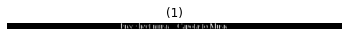

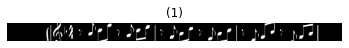

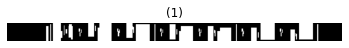

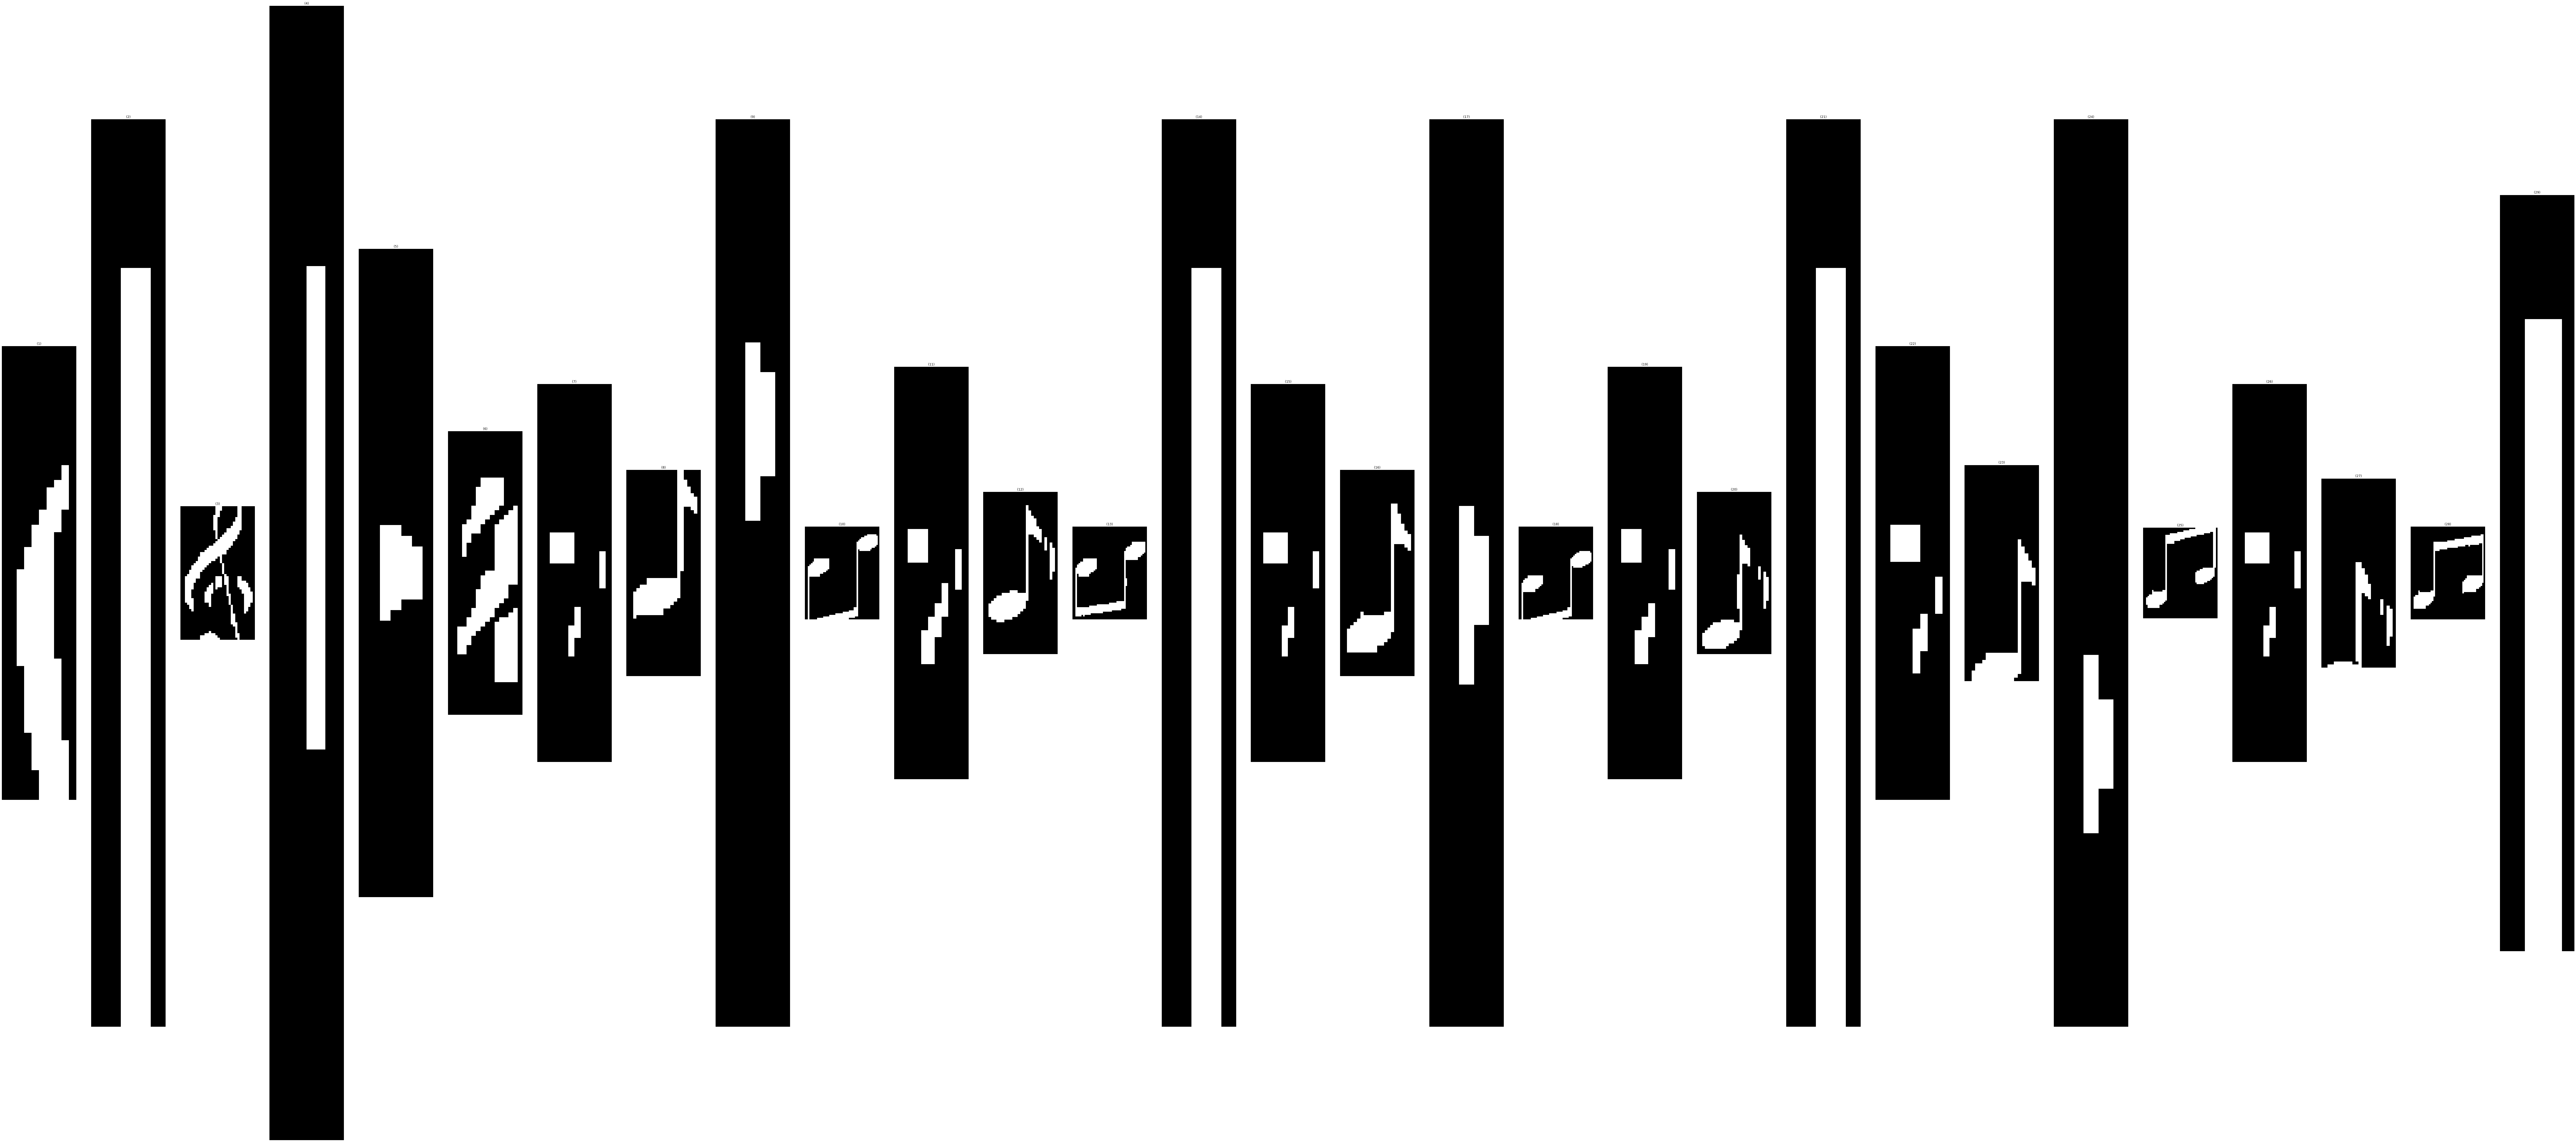

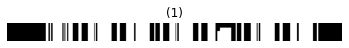

In [164]:
# charachter segmentation 
def charachterSegmentation(img,loops=9):
        original = img.copy()
        res = np.copy(img)
        se = np.ones((1,int(img.shape[1]*0.05)))
        se2 = np.array([[1,0,1],[0,0,0],[1,0,1]])
        se3 = np.array([[0,1,0],[0,1,0],[0,1,0]])
        # res = erosion(res)
        #res = sk.morphology.opening(res)
        # res = median(res)
#         for i in range(loops):
#             res = sk.morphology.erosion(res)
#             res = sk.morphology.dilation(res,se2)
#             res = sk.morphology.dilation(res,se3)
#         for i in range(19):
#             res = sk.morphology.dilation(res,se)
            
#         se = np.ones((1,int(img.shape[1]*0.9)))
#         res = sk.morphology.erosion(res,se)
        
        #res = sk.morphology.dilation(res,se2)
        #res = sk.morphology.dilation(res,se3)
            # res = median(res)
        #res = sk.morphology.dilation(res,se2)
        #res = sk.morphology.dilation(res,se3)
        #res =  sk.morphology.skeletonize(res == True)
        show_images([res])
       

        bounding_boxes = sk.measure.find_contours(res,0.8,fully_connected='high')
        newImg = np.zeros(res.shape)
        chars = []
        cnt = 0
        for box in bounding_boxes:
            [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
            Ymin -= 2
            Ymax += 2
            ar =  (Xmax-Xmin)/(Ymax-Ymin)
            if ( ( ar <= 1)):
                rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
                rr = rr.astype(int)
                cc = cc.astype(int)
                #chars.append(img[:,int(Xmin):int(Xmax)])
                newImg[rr, cc] = 1
                cnt += 1
        show_images([newImg])
        newImg = sk.morphology.closing(newImg)
        bounding_boxes = sk.measure.find_contours(newImg,0.8,fully_connected='high')
        newImg2 = np.zeros(newImg.shape)
        chars = []
        cnt = 0
        for box in bounding_boxes:
            #print("j")
            [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
            Ymin -= 2
            Ymax += 2
            ar =  (Xmax-Xmin)/(Ymax-Ymin)
            if ( ar<=1):
                rr, cc = sk.draw.rectangle(start = (0,Xmin), end = (img.shape[0],Xmax), shape=newImg.shape)
                rr = rr.astype(int)
                cc = cc.astype(int)
                newImg[rr, cc] = 1
                
                #chars.append(img[:,int(Xmin):int(Xmax)])
                #print(Xmin,Xmax)
                #show_images([chars[-1]])
        bounding_boxes = sk.measure.find_contours(newImg,0.8,fully_connected='high')
        chars = []
        cnt = 0
        for box in bounding_boxes:
            #print("j")
            [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
            Xmin = min(Xmin-2,0)
            Xmax += 2
            ar =  (Xmax-Xmin)/(Ymax-Ymin)
            if ( ar<=1):
                rr, cc = sk.draw.rectangle(start = (0,Xmin), end = (img.shape[0],Xmax), shape=newImg.shape)
                rr = rr.astype(int)
                cc = cc.astype(int)
                newImg[rr, cc] = 1

        #  fixing segmentation problem
        i,j,N,M,x1,x2,maxDiff,currDiff = 0,0,newImg.shape[0],newImg.shape[1],-1,-1,1,0
        while i < N:
            while j < M:
                if x1 == -1 and newImg[i][j] == True:
                    x1 = j
                elif x1 != -1 and newImg[i][j] == False and currDiff >= maxDiff:
                    chars.append(original[:,x1:j])
                    x1 = -1
                    currDiff = 0
                elif  x1 != -1 and newImg[i][j] == False:
                      currDiff += 1  
                j+= 1
            i += 1
        show_images(chars)
        show_images([newImg])
        #show_images([res,newImg,newImg2])
        #print(cnt)
        return chars

#for img in newImgs:
show_images([newImgs[0]])
chars = charachterSegmentation(newImgs[1],6)


In [13]:
# trying SIFT
import cv2 as cv
img1 = chars[3].copy()
img2 = chars[-4].copy()
# original = img1.copy()

img1 = (img1 < sk.filters.threshold_otsu(img1)).astype(int)
img1 = np.uint8(rgb2gray(img1)*255)

img2 = (img2 < sk.filters.threshold_otsu(img2)).astype(int)
img2 = np.uint8(rgb2gray(img2)*255)

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1,des1 = sift.detectAndCompute(img1,None)
kp2,des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params (KNN with k=2)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_images([img1,img2,img3],["original image 1","original image 2","matching between 1&2 using KNN"])

ModuleNotFoundError: No module named 'cv2'